In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
from scipy.ndimage import label, binary_closing, gaussian_filter1d, binary_dilation

#### Load Example Data from KPLO Spacecraft 

In [2]:
"Load Data"
data = np.load("b_kplo.npy") # X axis
print(np.isnan(data).sum())
B = data[1:,2,:15000]
sample_rate = 1

0


In [3]:
data.shape

(3, 3, 86400)

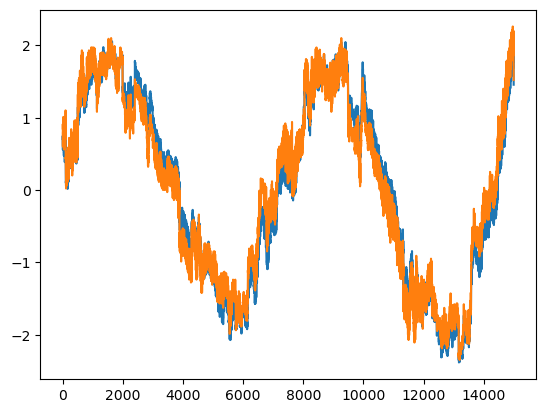

In [4]:
# fill in missing data
#B[0] -= np.mean(B[0]);  B[1] -= np.mean(B[1])
B = (B.T - np.mean(B, axis=1)).T
plt.plot(B.T)

In [16]:
"Wavelet Transform"
transform = Transform(
    data= B[0],
    fs = sample_rate,
    wavelet=Morlet(1,1), # Wavelet to use
    pad_method=None, # Padding method for the convolution calls np.pad. Set to None if no padding
    scales = 'dyadic'

)

c:\Users\aphoffm2\Documents\GitHub\InvertibleWavelets\invertiblewavelets\transform.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  s0 = 1.0 / center_freq
c:\Users\aphoffm2\Documents\GitHub\InvertibleWavelets\invertiblewavelets\transform.py:158: RuntimeWarning: divide by zero encountered in log2
  J = int(np.floor(np.log2(s_max / s0) / dj))


OverflowError: cannot convert float infinity to integer

In [14]:
1/0.003

333.3333333333333

In [10]:
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

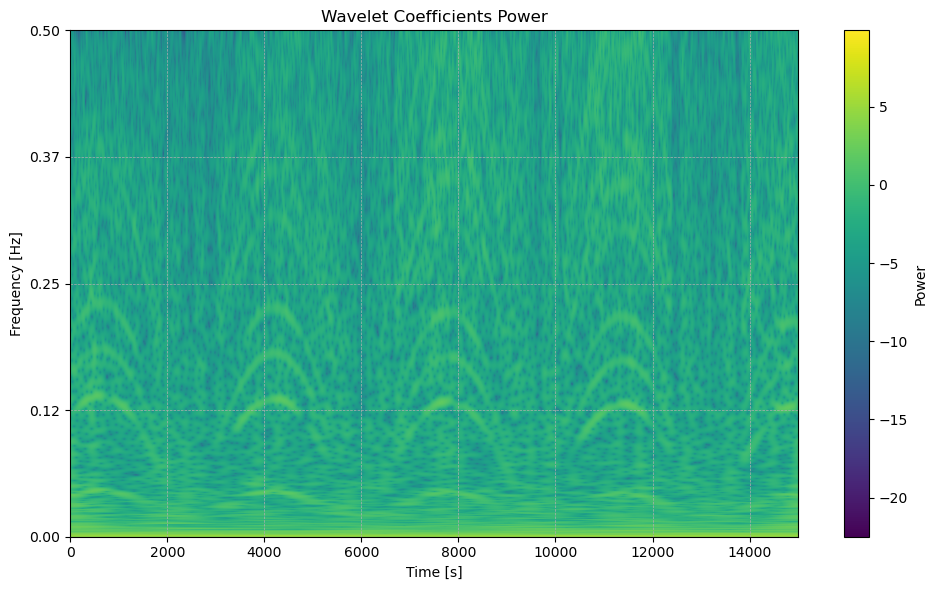

In [11]:
transform.power_scalogram(w2)

C:\Users\aphoffm2\AppData\Local\Temp\1\ipykernel_12228\404910274.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  mixing_matrices[:, 1, 1] = k_hat           # Second row second column is k_hat


Max
Max
Max
Max
Max
Max
Max


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


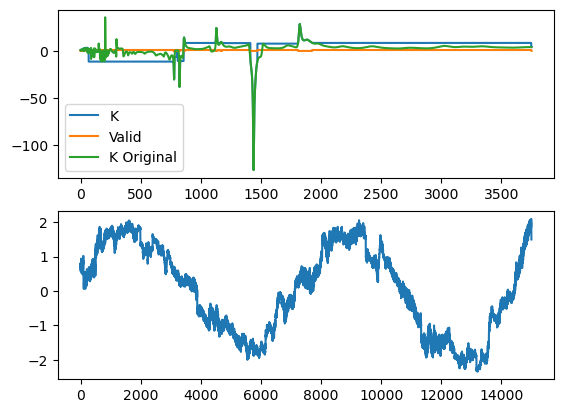

In [12]:
dw = w2-w1
wc1 = np.sum(dw*w1.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)
wc2 = np.sum(dw*w2.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)

# Calculate the K factor
k_hat = wc2/wc1#np.mean(dw*w2.conj() / (dw*w1.conj()) , axis=1).real
k_hat_original = np.copy(k_hat)
# Check the condition of each sub-sensing matrix
mixing_matrices = np.empty((len(k_hat), 2, 2))
mixing_matrices[:, 0, :] = [1, 1]          # First row is always [1, 1]
mixing_matrices[:, 1, 0] = 1               # Second row first column is 1
mixing_matrices[:, 1, 1] = k_hat           # Second row second column is k_hat

# Compute singular values for all matrices at once
_, s, _ = np.linalg.svd(mixing_matrices)
condition_numbers = s[:, 0] / s[:, 1]

# Create mask where condition is bad
valid_mask = condition_numbers < 10
valid_mask = binary_closing(valid_mask, structure=np.ones(5))
#valid_mask = binary_dilation(valid_mask, structure=np.ones(50))

# Label contiguous segments
labeled_mask, num_segments = label(valid_mask)

# Process each segment
for seg_id in range(1, num_segments + 1):
    # Extract frequency bins in the current segment
    segment_mask = labeled_mask == seg_id
    k_segment = k_hat[segment_mask]

    if(np.mean(k_segment) < 1):
        k_hat[segment_mask] = np.min(k_segment)
    else:
        print("Max")
        k_hat[segment_mask] = np.max(k_segment)



# Apply K to compute clean signal
k = k_hat[:, np.newaxis]
weights = 1 / (condition_numbers + 1)
weights = weights[:, np.newaxis]


transform.pad_width

epsilon = 1e-6
denominator = k - 1
#denominator[np.abs(denominator) < epsilon] = epsilon * np.sign(denominator[np.abs(denominator) < epsilon])
w_clean = np.copy(w1)
w_clean[:,transform.pad_width:-transform.pad_width] = weights * ((k * w1[:,transform.pad_width:-transform.pad_width] - w2[:,transform.pad_width:-transform.pad_width]) / (denominator)) + (1 - weights) * ((w1[:,transform.pad_width:-transform.pad_width] + w2[:,transform.pad_width:-transform.pad_width]) / 2)


w_clean = np.copy(w1)/2 + np.copy(w2) / 2
w_clean[valid_mask] = (k[valid_mask] * w1[valid_mask] - w2[valid_mask]) / (k[valid_mask] - 1)


# Find nan values and replace them with the average of the two sensors
nan_mask = np.isnan(w_clean[:, 0])
weights_1 = 1/(np.abs(wc1) +1)[:, np.newaxis]
weights_2 = 1/(np.abs(wc2) +1)[:, np.newaxis]
w_clean[nan_mask] = (weights_1[nan_mask]*w1[nan_mask]+ weights_2[nan_mask]*w2[nan_mask]) / (weights_1[nan_mask] + weights_2[nan_mask])



result = transform.inverse(np.copy(w_clean))


fig, ax = plt.subplots(2,1)
ax[0].plot( k_hat, label='K')
ax[0].plot(np.array(valid_mask, dtype=int), label='Valid')
ax[0].plot(k_hat_original, label='K Original')
ax[0].legend()
ax[1].plot(result)


In [13]:
transform.power_scalogram(w1, vmin=0,  title = 'noisy 1 coeffs')
transform.power_scalogram(transform.forward(data), vmin=0, title = 'True coeffs')
transform.power_scalogram(w_clean, vmin=0, title = 'Cleaned Signal coeffs')
w = transform.forward(result)
transform.power_scalogram(w, vmin=0, title = 'Clean Signal after icwt and cwt again')

KeyboardInterrupt: 

'\nThis chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? \n'

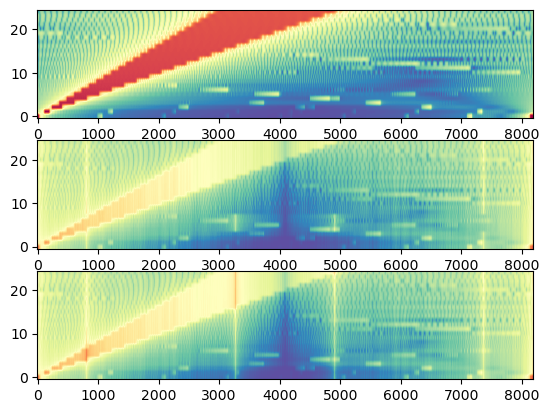

In [33]:
# https://www.sciencedirect.com/science/article/abs/pii/S0888327002915244 Aliasing??
fig, ax = plt.subplots(3,1)
ax[0].imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[1].imshow(np.log(np.abs(np.fft.fft(w_clean, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[2].imshow(np.log(np.abs(np.fft.fft(w1, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')


"""
This chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? 
"""

In [5]:
transform.b

1

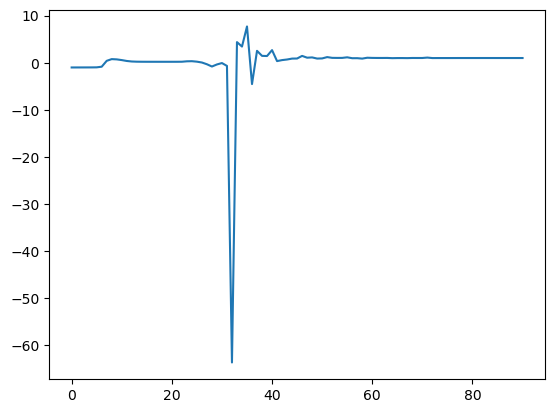

In [6]:

from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)

#### WAICUP


(2.3926963860090864+0j)


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


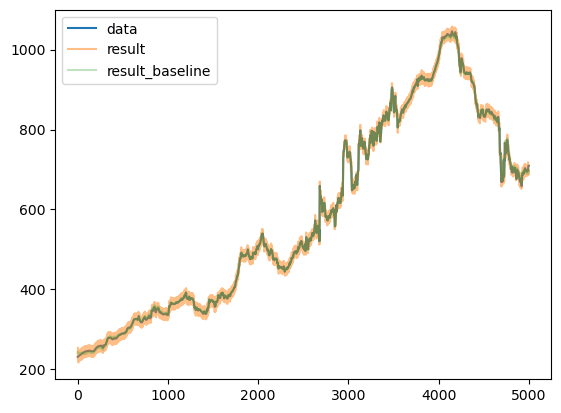

In [35]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend =True
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result', alpha=0.5)
plt.plot(result_baseline, label='result_baseline', alpha=0.3)
plt.legend()

In [8]:
1/6.10351562e-03



163.84000013421775